# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
filename = 'netifier-coreset'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [ ]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.8167, F1 Micro: 0.259, F1 Macro: 0.187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8417, F1 Micro: 0.4813, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3739, Accuracy: 0.8522, F1 Micro: 0.5456, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8609, F1 Micro: 0.6048, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2618, Accuracy: 0.867, F1 Micro: 0.678, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2249, Accuracy: 0.8678, F1 Micro: 0.68, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.8722, F1 Micro: 0.6715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4338, Accuracy: 0.7961, F1 Micro: 0.327, F1 Macro: 0.1679
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2454, Accuracy: 0.8222, F1 Micro: 0.3282, F1 Macro: 0.2016
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.8208, F1 Micro: 0.3666, F1 Macro: 0.2241
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.8459, F1 Micro: 0.5582, F1 Macro: 0.5116
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.8683, F1 Micro: 0.6486, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.8708, F1 Micro: 0.6661, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0933, Accuracy: 0.8716, F1 Micro: 0.6754, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.8722, F1 Micro: 0.6873, F1 Macro: 0.6764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.05

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4697, Accuracy: 0.778, F1 Micro: 0.5618, F1 Macro: 0.5709
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3014, Accuracy: 0.8577, F1 Micro: 0.6298, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2371, Accuracy: 0.8677, F1 Micro: 0.6499, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2006, Accuracy: 0.8775, F1 Micro: 0.6869, F1 Macro: 0.6818
Epoch 5/10, Train Loss: 0.1685, Accuracy: 0.8656, F1 Micro: 0.6004, F1 Macro: 0.5654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.8775, F1 Micro: 0.7012, F1 Macro: 0.6912
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.883, F1 Micro: 0.7064, F1 Macro: 0.6979
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.8839, F1 Micro: 0.7078, F1 Macro: 0.7019
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.8823, F1 Micro: 0.6938, F1 Macro: 0.6779
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4523, Accuracy: 0.8119, F1 Micro: 0.5863, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2863, Accuracy: 0.8647, F1 Micro: 0.638, F1 Macro: 0.6349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.8797, F1 Micro: 0.6632, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.8867, F1 Micro: 0.695, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.8836, F1 Micro: 0.698, F1 Macro: 0.6769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.8875, F1 Micro: 0.7201, F1 Macro: 0.703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.8867, F1 Micro: 0.7368, F1 Macro: 0.7306
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0685, Accuracy: 0.8914, F1 Micro: 0.7372, F1 Macro: 0.7221
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.8933, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4487, Accuracy: 0.8483, F1 Micro: 0.5694, F1 Macro: 0.529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2882, Accuracy: 0.8795, F1 Micro: 0.6939, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2217, Accuracy: 0.888, F1 Micro: 0.7124, F1 Macro: 0.694
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.882, F1 Micro: 0.6707, F1 Macro: 0.6348
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.8888, F1 Micro: 0.7455, F1 Macro: 0.7379
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.8953, F1 Micro: 0.7316, F1 Macro: 0.7179
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.8953, F1 Micro: 0.7417, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.8959, F1 Micro: 0.753, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.8967, F1 Micro: 0.7558, F1 Macro: 0.7488
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4329, Accuracy: 0.8678, F1 Micro: 0.6487, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.8855, F1 Micro: 0.7186, F1 Macro: 0.7025
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.8875, F1 Micro: 0.7156, F1 Macro: 0.6905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.8944, F1 Micro: 0.7274, F1 Macro: 0.7139
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.8936, F1 Micro: 0.7164, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.8958, F1 Micro: 0.7356, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.8959, F1 Micro: 0.7472, F1 Macro: 0.7282
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.8925, F1 Micro: 0.7356, F1 Macro: 0.7235
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.8984, F1 Micro: 0.7635, F1 Macro: 0.7547
Epoch 10/10, Train Loss: 0.0425, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4328, Accuracy: 0.8755, F1 Micro: 0.6785, F1 Macro: 0.6628
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2609, Accuracy: 0.8886, F1 Micro: 0.736, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.8895, F1 Micro: 0.7591, F1 Macro: 0.7578
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.8942, F1 Micro: 0.7494, F1 Macro: 0.7376
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.8977, F1 Micro: 0.7472, F1 Macro: 0.7355
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.8986, F1 Micro: 0.757, F1 Macro: 0.7492
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.8991, F1 Micro: 0.7426, F1 Macro: 0.7264
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.8973, F1 Micro: 0.7668, F1 Macro: 0.7602
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.8973, F1 Micro: 0.7484, F1 Macro: 0.7354
Epoch 10/10, Train Loss: 0.0406, Accuracy: 0.9017, F1 Micro: 0.7606, F1 Macro: 0.752
Iteration 3122: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4098, Accuracy: 0.8763, F1 Micro: 0.673, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2459, Accuracy: 0.8869, F1 Micro: 0.7474, F1 Macro: 0.7411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.8931, F1 Micro: 0.7511, F1 Macro: 0.7455
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.8959, F1 Micro: 0.7448, F1 Macro: 0.7306
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.8938, F1 Micro: 0.7571, F1 Macro: 0.7478
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.8983, F1 Micro: 0.76, F1 Macro: 0.7512
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.8983, F1 Micro: 0.7484, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.905, F1 Micro: 0.7699, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9028, F1 Micro: 0.7733, F1 Macro: 0.7673
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4199, Accuracy: 0.8756, F1 Micro: 0.7056, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.8919, F1 Micro: 0.7471, F1 Macro: 0.7398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9003, F1 Micro: 0.7603, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9031, F1 Micro: 0.7744, F1 Macro: 0.7706
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9039, F1 Micro: 0.7718, F1 Macro: 0.7638
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.898, F1 Micro: 0.752, F1 Macro: 0.7399
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9016, F1 Micro: 0.761, F1 Macro: 0.752
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9013, F1 Micro: 0.7586, F1 Macro: 0.7513
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9031, F1 Micro: 0.7662, F1 Macro: 0.7577
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.9031, F1 Micro: 0.7606, F1 Macro: 0.7525
Iteration 3711: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4018, Accuracy: 0.8758, F1 Micro: 0.6939, F1 Macro: 0.676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.8961, F1 Micro: 0.7527, F1 Macro: 0.7484
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.8959, F1 Micro: 0.737, F1 Macro: 0.7171
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9009, F1 Micro: 0.7671, F1 Macro: 0.7623
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9003, F1 Micro: 0.7561, F1 Macro: 0.7475
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.8969, F1 Micro: 0.7656, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.9016, F1 Micro: 0.7684, F1 Macro: 0.7652
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.8992, F1 Micro: 0.7552, F1 Macro: 0.7468
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.898, F1 Micro: 0.7524, F1 Macro: 0.7415
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.9023, F1 Micro: 0.7711, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3932, Accuracy: 0.8819, F1 Micro: 0.7097, F1 Macro: 0.705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2433, Accuracy: 0.8928, F1 Micro: 0.7269, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.8986, F1 Micro: 0.7583, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9008, F1 Micro: 0.7651, F1 Macro: 0.7577
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.8983, F1 Micro: 0.7399, F1 Macro: 0.7237
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9005, F1 Micro: 0.7461, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.8955, F1 Micro: 0.7662, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9011, F1 Micro: 0.7679, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9, F1 Micro: 0.7701, F1 Macro: 0.7676
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3963, Accuracy: 0.8778, F1 Micro: 0.6672, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2336, Accuracy: 0.893, F1 Micro: 0.7203, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2049, Accuracy: 0.9033, F1 Micro: 0.7723, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9044, F1 Micro: 0.7725, F1 Macro: 0.7659
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.8998, F1 Micro: 0.7683, F1 Macro: 0.7666
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9038, F1 Micro: 0.7642, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9059, F1 Micro: 0.7811, F1 Macro: 0.7778
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9041, F1 Micro: 0.7687, F1 Macro: 0.7644
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9016, F1 Micro: 0.7783, F1 Macro: 0.7753
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.9003, F1 Micro: 0.7765, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3936, Accuracy: 0.8797, F1 Micro: 0.7101, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.895, F1 Micro: 0.7449, F1 Macro: 0.7311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9003, F1 Micro: 0.7614, F1 Macro: 0.7571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.9045, F1 Micro: 0.7674, F1 Macro: 0.7617
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9045, F1 Micro: 0.766, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9023, F1 Micro: 0.7743, F1 Macro: 0.7712
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9039, F1 Micro: 0.7711, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9058, F1 Micro: 0.7798, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9016, F1 Micro: 0.7626, F1 Macro: 0.7578
Epoch 10/10, Train Loss: 0.0327, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3862, Accuracy: 0.8834, F1 Micro: 0.7063, F1 Macro: 0.6966
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2334, Accuracy: 0.8927, F1 Micro: 0.7646, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9038, F1 Micro: 0.7708, F1 Macro: 0.7631
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.903, F1 Micro: 0.7614, F1 Macro: 0.7524
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9008, F1 Micro: 0.7615, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9045, F1 Micro: 0.7741, F1 Macro: 0.7712
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9002, F1 Micro: 0.7655, F1 Macro: 0.7587
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.8958, F1 Micro: 0.7721, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9016, F1 Micro: 0.7774, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.037, Accuracy: 0.9038, F1 Micro: 0.7674, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3875, Accuracy: 0.8833, F1 Micro: 0.7083, F1 Macro: 0.6863
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2356, Accuracy: 0.8997, F1 Micro: 0.7548, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.902, F1 Micro: 0.7628, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.8958, F1 Micro: 0.7776, F1 Macro: 0.7768
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9041, F1 Micro: 0.7649, F1 Macro: 0.7542
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.9033, F1 Micro: 0.7672, F1 Macro: 0.7632
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9033, F1 Micro: 0.7725, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9031, F1 Micro: 0.7825, F1 Macro: 0.7796
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9014, F1 Micro: 0.7728, F1 Macro: 0.7697
Epoch 10/10, Train Loss: 0.0355, Accuracy: 0.905, F1 Micro: 0.7725, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.372, Accuracy: 0.8848, F1 Micro: 0.7201, F1 Macro: 0.7184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2363, Accuracy: 0.9006, F1 Micro: 0.7576, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.9039, F1 Micro: 0.7636, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9042, F1 Micro: 0.7808, F1 Macro: 0.7802
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9042, F1 Micro: 0.765, F1 Macro: 0.7564
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9041, F1 Micro: 0.7655, F1 Macro: 0.7521
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9061, F1 Micro: 0.7778, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9084, F1 Micro: 0.7792, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9064, F1 Micro: 0.7832, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0332, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3811, Accuracy: 0.8864, F1 Micro: 0.7338, F1 Macro: 0.7294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.8981, F1 Micro: 0.7494, F1 Macro: 0.7431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9002, F1 Micro: 0.7575, F1 Macro: 0.7524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9075, F1 Micro: 0.7628, F1 Macro: 0.7465
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9061, F1 Micro: 0.7709, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9028, F1 Micro: 0.773, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.905, F1 Micro: 0.7771, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9072, F1 Micro: 0.7772, F1 Macro: 0.7724
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9017, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3787, Accuracy: 0.8902, F1 Micro: 0.7362, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.8989, F1 Micro: 0.7512, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.189, Accuracy: 0.902, F1 Micro: 0.7582, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9017, F1 Micro: 0.7606, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.908, F1 Micro: 0.7793, F1 Macro: 0.7705
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9045, F1 Micro: 0.7748, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9044, F1 Micro: 0.7814, F1 Macro: 0.779
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9039, F1 Micro: 0.773, F1 Macro: 0.7684
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9019, F1 Micro: 0.781, F1 Macro: 0.7779
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.376, Accuracy: 0.8916, F1 Micro: 0.7323, F1 Macro: 0.7103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2361, Accuracy: 0.9005, F1 Micro: 0.7744, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9042, F1 Micro: 0.7772, F1 Macro: 0.7704
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.9044, F1 Micro: 0.7698, F1 Macro: 0.7631
Epoch 5/10, Train Loss: 0.1129, Accuracy: 0.9008, F1 Micro: 0.7399, F1 Macro: 0.7311
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9053, F1 Micro: 0.7777, F1 Macro: 0.7757
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.8998, F1 Micro: 0.7736, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9, F1 Micro: 0.7819, F1 Macro: 0.7826
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9027, F1 Micro: 0.7637, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.029, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3603, Accuracy: 0.8891, F1 Micro: 0.7137, F1 Macro: 0.7081
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2323, Accuracy: 0.8955, F1 Micro: 0.7579, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9072, F1 Micro: 0.7925, F1 Macro: 0.7867
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9064, F1 Micro: 0.7811, F1 Macro: 0.779
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9028, F1 Micro: 0.7691, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9072, F1 Micro: 0.7762, F1 Macro: 0.7713
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.9056, F1 Micro: 0.776, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9002, F1 Micro: 0.773, F1 Macro: 0.7735
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9039, F1 Micro: 0.7761, F1 Macro: 0.7743
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.902, F1 Micro: 0.7796, F1 Macro: 0.7795
Iteration 5841: Accuracy: 0.9072, F1 Micro: 0.7925, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3655, Accuracy: 0.892, F1 Micro: 0.7473, F1 Macro: 0.7401
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.239, Accuracy: 0.8923, F1 Micro: 0.7715, F1 Macro: 0.7684
Epoch 3/10, Train Loss: 0.1866, Accuracy: 0.902, F1 Micro: 0.7656, F1 Macro: 0.749
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9045, F1 Micro: 0.775, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.9052, F1 Micro: 0.7834, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9041, F1 Micro: 0.7835, F1 Macro: 0.7845
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9027, F1 Micro: 0.7757, F1 Macro: 0.7742
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.902, F1 Micro: 0.7753, F1 Macro: 0.7715
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9058, F1 Micro: 0.7741, F1 Macro: 0.7675
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9072, F1 Micro: 0.7832, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3707, Accuracy: 0.8891, F1 Micro: 0.7394, F1 Macro: 0.7377
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2361, Accuracy: 0.8991, F1 Micro: 0.756, F1 Macro: 0.7411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9025, F1 Micro: 0.7759, F1 Macro: 0.773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9042, F1 Micro: 0.7793, F1 Macro: 0.7748
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9053, F1 Micro: 0.7749, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.8995, F1 Micro: 0.7803, F1 Macro: 0.7784
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9061, F1 Micro: 0.7723, F1 Macro: 0.7627
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9038, F1 Micro: 0.7686, F1 Macro: 0.757
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9069, F1 Micro: 0.7718, F1 Macro: 0.7657
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9052, F1 Micro: 0.7771, F1 Ma

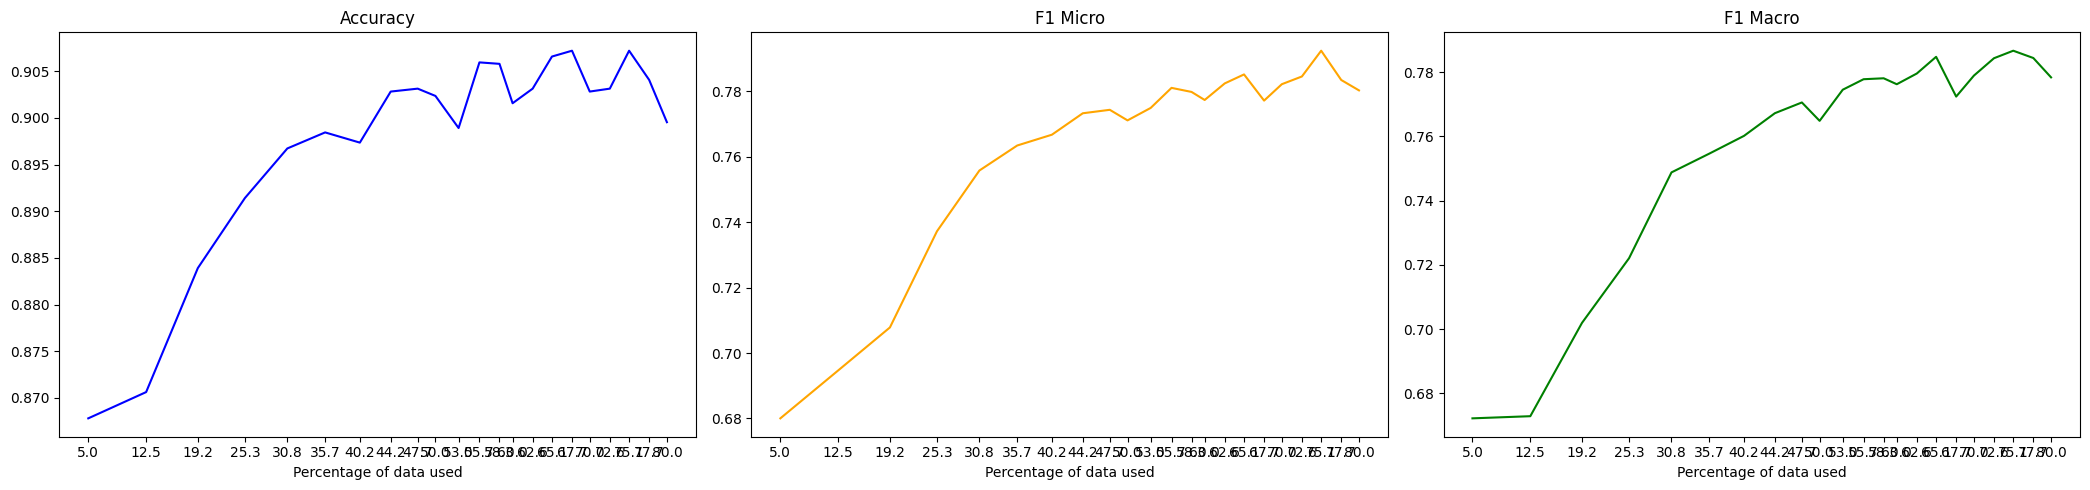

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5968, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4973, Accuracy: 0.7958, F1 Micro: 0.0815, F1 Macro: 0.0678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4357, Accuracy: 0.8263, F1 Micro: 0.3178, F1 Macro: 0.2216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4166, Accuracy: 0.8441, F1 Micro: 0.4791, F1 Macro: 0.4013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3434, Accuracy: 0.848, F1 Micro: 0.5003, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3181, Accuracy: 0.8561, F1 Micro: 0.569, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.28, Accuracy: 0.8608, F1 Micro: 0.6101, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2362, Accuracy: 0.8725, F1 Micro: 0.6686, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1874, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4179, Accuracy: 0.7795, F1 Micro: 0.312, F1 Macro: 0.1515
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.8273, F1 Micro: 0.4905, F1 Macro: 0.3907
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.8342, F1 Micro: 0.4002, F1 Macro: 0.3349
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.8553, F1 Micro: 0.6012, F1 Macro: 0.5368
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.8695, F1 Micro: 0.6588, F1 Macro: 0.648
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.8531, F1 Micro: 0.5323, F1 Macro: 0.4478
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.8806, F1 Micro: 0.7077, F1 Macro: 0.6991
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.8744, F1 Micro: 0.6724, F1 Macro: 0.6527
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.8745, F1 Micro: 0.6896, F1 Macro: 0.6678
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.8755, F1 Micro: 0.6919, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.485, Accuracy: 0.7792, F1 Micro: 0.5725, F1 Macro: 0.5784
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2992, Accuracy: 0.8595, F1 Micro: 0.6609, F1 Macro: 0.6626
Epoch 3/10, Train Loss: 0.2424, Accuracy: 0.8692, F1 Micro: 0.6458, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1973, Accuracy: 0.8816, F1 Micro: 0.7073, F1 Macro: 0.7028
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.885, F1 Micro: 0.7147, F1 Macro: 0.7077
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.882, F1 Micro: 0.6952, F1 Macro: 0.6756
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.8841, F1 Micro: 0.7015, F1 Macro: 0.6926
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.8827, F1 Micro: 0.7012, F1 Macro: 0.6879
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.8833, F1 Micro: 0.7092, F1 Macro: 0.7034
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0.8806, F1 Micro: 0.7025, F1 Macro: 0.6897
Iteration 1496: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4297, Accuracy: 0.7947, F1 Micro: 0.6013, F1 Macro: 0.618
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2869, Accuracy: 0.8742, F1 Micro: 0.7002, F1 Macro: 0.6878
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2283, Accuracy: 0.887, F1 Micro: 0.7307, F1 Macro: 0.7197
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.8888, F1 Micro: 0.7129, F1 Macro: 0.6844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.8906, F1 Micro: 0.7318, F1 Macro: 0.7228
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.89, F1 Micro: 0.7049, F1 Macro: 0.6753
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.89, F1 Micro: 0.7282, F1 Macro: 0.7167
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.8914, F1 Micro: 0.7167, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.8831, F1 Micro: 0.7397, F1 Macro: 0.7383
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4498, Accuracy: 0.8503, F1 Micro: 0.5412, F1 Macro: 0.4711
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.8845, F1 Micro: 0.7393, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2261, Accuracy: 0.8973, F1 Micro: 0.7441, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.8972, F1 Micro: 0.7457, F1 Macro: 0.728
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.8995, F1 Micro: 0.7437, F1 Macro: 0.7302
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.8994, F1 Micro: 0.7453, F1 Macro: 0.7304
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.8963, F1 Micro: 0.7548, F1 Macro: 0.7475
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.8973, F1 Micro: 0.7416, F1 Macro: 0.7247
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.8981, F1 Micro: 0.7485, F1 Macro: 0.742
Epoch 10/10, Train Loss: 0.0438, Accuracy: 0.8986, F1 Micro: 0.7472, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4276, Accuracy: 0.8547, F1 Micro: 0.6608, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.8908, F1 Micro: 0.7389, F1 Macro: 0.7386
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.8947, F1 Micro: 0.7319, F1 Macro: 0.7112
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.89, F1 Micro: 0.6958, F1 Macro: 0.6677
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.8986, F1 Micro: 0.7363, F1 Macro: 0.7146
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9005, F1 Micro: 0.7513, F1 Macro: 0.7367
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.8977, F1 Micro: 0.7495, F1 Macro: 0.7379
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.8877, F1 Micro: 0.7591, F1 Macro: 0.7612
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.8983, F1 Micro: 0.7468, F1 Macro: 0.7364
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.8972, F1 Micro: 0.7487, F1 Macro: 0.7385
Iteration 2777: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4293, Accuracy: 0.8703, F1 Micro: 0.664, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.256, Accuracy: 0.8939, F1 Micro: 0.7409, F1 Macro: 0.7321
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2059, Accuracy: 0.8973, F1 Micro: 0.7425, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9041, F1 Micro: 0.768, F1 Macro: 0.7621
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9036, F1 Micro: 0.7658, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9036, F1 Micro: 0.7707, F1 Macro: 0.762
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.898, F1 Micro: 0.7695, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9038, F1 Micro: 0.764, F1 Macro: 0.7536
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9031, F1 Micro: 0.7648, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0464, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4126, Accuracy: 0.8722, F1 Micro: 0.668, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.8936, F1 Micro: 0.7408, F1 Macro: 0.7274
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.8992, F1 Micro: 0.7699, F1 Macro: 0.769
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9053, F1 Micro: 0.7683, F1 Macro: 0.7555
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9038, F1 Micro: 0.7601, F1 Macro: 0.7484
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9011, F1 Micro: 0.7574, F1 Macro: 0.7477
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9019, F1 Micro: 0.7678, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.903, F1 Micro: 0.7786, F1 Macro: 0.7756
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9031, F1 Micro: 0.7673, F1 Macro: 0.764
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.8997, F1 Micro: 0.7538, F1 Macro: 0.7424
Iteration 3432: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4016, Accuracy: 0.8745, F1 Micro: 0.7158, F1 Macro: 0.7162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.8928, F1 Micro: 0.7636, F1 Macro: 0.7627
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.9017, F1 Micro: 0.7483, F1 Macro: 0.7389
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.8988, F1 Micro: 0.7437, F1 Macro: 0.7342
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.8998, F1 Micro: 0.7549, F1 Macro: 0.7463
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9013, F1 Micro: 0.7619, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.9039, F1 Micro: 0.767, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9025, F1 Micro: 0.7699, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9023, F1 Micro: 0.7749, F1 Macro: 0.771
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.8986, F1 Micro: 0.7559, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3935, Accuracy: 0.8802, F1 Micro: 0.7071, F1 Macro: 0.7053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2307, Accuracy: 0.8941, F1 Micro: 0.7312, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9033, F1 Micro: 0.7669, F1 Macro: 0.7606
Epoch 4/10, Train Loss: 0.1424, Accuracy: 0.8994, F1 Micro: 0.7562, F1 Macro: 0.7463
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9045, F1 Micro: 0.7723, F1 Macro: 0.7633
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.8991, F1 Micro: 0.7395, F1 Macro: 0.7341
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.9011, F1 Micro: 0.7649, F1 Macro: 0.7574
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9022, F1 Micro: 0.7753, F1 Macro: 0.7708
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9059, F1 Micro: 0.7765, F1 Macro: 0.7714
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3853, Accuracy: 0.8847, F1 Micro: 0.7254, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2302, Accuracy: 0.8973, F1 Micro: 0.7659, F1 Macro: 0.7641
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9034, F1 Micro: 0.7623, F1 Macro: 0.7504
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9048, F1 Micro: 0.765, F1 Macro: 0.7591
Epoch 5/10, Train Loss: 0.1096, Accuracy: 0.9039, F1 Micro: 0.7593, F1 Macro: 0.7495
Epoch 6/10, Train Loss: 0.0822, Accuracy: 0.903, F1 Micro: 0.7641, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.9048, F1 Micro: 0.7786, F1 Macro: 0.7742
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9028, F1 Micro: 0.7748, F1 Macro: 0.7705
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9028, F1 Micro: 0.7735, F1 Macro: 0.7698
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.9038, F1 Micro: 0.766, F1 Macro: 0.7555
Iteration 4120: Accuracy: 0.9048, F1 Micro: 0.7786, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.8866, F1 Micro: 0.7339, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2211, Accuracy: 0.8989, F1 Micro: 0.748, F1 Macro: 0.7432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.9044, F1 Micro: 0.7716, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9014, F1 Micro: 0.7785, F1 Macro: 0.7782
Epoch 5/10, Train Loss: 0.1112, Accuracy: 0.9025, F1 Micro: 0.7629, F1 Macro: 0.7575
Epoch 6/10, Train Loss: 0.0826, Accuracy: 0.9008, F1 Micro: 0.7697, F1 Macro: 0.7624
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.9031, F1 Micro: 0.7762, F1 Macro: 0.7723
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9016, F1 Micro: 0.7737, F1 Macro: 0.7688
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9008, F1 Micro: 0.7766, F1 Macro: 0.7777
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9036, F1 Micro: 0.7791, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3877, Accuracy: 0.8863, F1 Micro: 0.729, F1 Macro: 0.7173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2229, Accuracy: 0.9002, F1 Micro: 0.7453, F1 Macro: 0.7338
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.186, Accuracy: 0.9047, F1 Micro: 0.7741, F1 Macro: 0.7695
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9062, F1 Micro: 0.7653, F1 Macro: 0.7591
Epoch 5/10, Train Loss: 0.1105, Accuracy: 0.9062, F1 Micro: 0.7739, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0812, Accuracy: 0.9031, F1 Micro: 0.7786, F1 Macro: 0.7784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.8995, F1 Micro: 0.7787, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9064, F1 Micro: 0.7799, F1 Macro: 0.7774
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9044, F1 Micro: 0.7727, F1 Macro: 0.7645
Epoch 10/10, Train Loss: 0.032, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3736, Accuracy: 0.882, F1 Micro: 0.7401, F1 Macro: 0.7375
Epoch 2/10, Train Loss: 0.2282, Accuracy: 0.8958, F1 Micro: 0.7238, F1 Macro: 0.7114
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1869, Accuracy: 0.9056, F1 Micro: 0.7702, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9028, F1 Micro: 0.7821, F1 Macro: 0.7835
Epoch 5/10, Train Loss: 0.1123, Accuracy: 0.902, F1 Micro: 0.7782, F1 Macro: 0.7778
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0785, Accuracy: 0.9044, F1 Micro: 0.7875, F1 Macro: 0.7867
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9069, F1 Micro: 0.7791, F1 Macro: 0.7734
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.9081, F1 Micro: 0.7821, F1 Macro: 0.7775
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9073, F1 Micro: 0.7718, F1 Macro: 0.764
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9072, F1 Micro: 0.786, F1 Macro: 0.7836
Iteration 4663: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3675, Accuracy: 0.8928, F1 Micro: 0.748, F1 Macro: 0.7423
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2332, Accuracy: 0.9003, F1 Micro: 0.7663, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1819, Accuracy: 0.905, F1 Micro: 0.7818, F1 Macro: 0.7782
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.9019, F1 Micro: 0.7744, F1 Macro: 0.7733
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9055, F1 Micro: 0.7773, F1 Macro: 0.7767
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9055, F1 Micro: 0.7685, F1 Macro: 0.7638
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9073, F1 Micro: 0.7765, F1 Macro: 0.7742
Epoch 8/10, Train Loss: 0.0446, Accuracy: 0.9083, F1 Micro: 0.7797, F1 Macro: 0.7718
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9041, F1 Micro: 0.7809, F1 Macro: 0.7778
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9078, F1 Micro: 0.775, F1 Macro: 0.7698
Iteration 4863: Accuracy: 0.905, F1 Micro: 0.7818, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3764, Accuracy: 0.8892, F1 Micro: 0.7081, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.9009, F1 Micro: 0.7652, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.191, Accuracy: 0.9041, F1 Micro: 0.7751, F1 Macro: 0.774
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9053, F1 Micro: 0.7746, F1 Macro: 0.769
Epoch 5/10, Train Loss: 0.1091, Accuracy: 0.902, F1 Micro: 0.7586, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0856, Accuracy: 0.9058, F1 Micro: 0.7824, F1 Macro: 0.7781
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9083, F1 Micro: 0.7757, F1 Macro: 0.7709
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9056, F1 Micro: 0.7823, F1 Macro: 0.7803
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9019, F1 Micro: 0.7733, F1 Macro: 0.7711
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9034, F1 Micro: 0.7671, F1 Macro: 0.7593
Iteration 5063: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8791, F1 Micro: 0.6608, F1 Macro: 0.648
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2288, Accuracy: 0.9003, F1 Micro: 0.7647, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9042, F1 Micro: 0.765, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9041, F1 Micro: 0.7891, F1 Macro: 0.7891
Epoch 5/10, Train Loss: 0.1045, Accuracy: 0.9041, F1 Micro: 0.7741, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9044, F1 Micro: 0.7901, F1 Macro: 0.7874
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9059, F1 Micro: 0.783, F1 Macro: 0.7785
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9058, F1 Micro: 0.7839, F1 Macro: 0.7777
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9061, F1 Micro: 0.771, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9036, F1 Micro: 0.7858, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3664, Accuracy: 0.8925, F1 Micro: 0.7362, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2306, Accuracy: 0.8998, F1 Micro: 0.7634, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9045, F1 Micro: 0.764, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9055, F1 Micro: 0.7927, F1 Macro: 0.7937
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.908, F1 Micro: 0.7837, F1 Macro: 0.7819
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9067, F1 Micro: 0.7875, F1 Macro: 0.7874
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9062, F1 Micro: 0.7834, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0471, Accuracy: 0.9094, F1 Micro: 0.7949, F1 Macro: 0.7938
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9084, F1 Micro: 0.7838, F1 Macro: 0.7839
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.9073, F1 Micro: 0.7857, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.372, Accuracy: 0.8908, F1 Micro: 0.7298, F1 Macro: 0.7118
Epoch 2/10, Train Loss: 0.2337, Accuracy: 0.8963, F1 Micro: 0.7263, F1 Macro: 0.6962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9048, F1 Micro: 0.773, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9042, F1 Micro: 0.7768, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9094, F1 Micro: 0.7824, F1 Macro: 0.7816
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9034, F1 Micro: 0.7743, F1 Macro: 0.7679
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.9064, F1 Micro: 0.7752, F1 Macro: 0.7664
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.905, F1 Micro: 0.7743, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9052, F1 Micro: 0.7814, F1 Macro: 0.7797
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.908, F1 Micro: 0.778, F1 Macro: 0.772
Iteration 5641: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3577, Accuracy: 0.8925, F1 Micro: 0.7263, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2228, Accuracy: 0.9048, F1 Micro: 0.7739, F1 Macro: 0.7632
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9058, F1 Micro: 0.7725, F1 Macro: 0.764
Epoch 4/10, Train Loss: 0.1501, Accuracy: 0.9036, F1 Micro: 0.765, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9092, F1 Micro: 0.7936, F1 Macro: 0.7923
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.9069, F1 Micro: 0.7788, F1 Macro: 0.7698
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9087, F1 Micro: 0.7914, F1 Macro: 0.7893
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.908, F1 Micro: 0.7793, F1 Macro: 0.7744
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9062, F1 Micro: 0.7835, F1 Macro: 0.785
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.9059, F1 Micro: 0.7827, F1 Macro: 0.7827
Iteration 5841: Accuracy: 0.9092, F1 Micro: 0.7936, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3667, Accuracy: 0.8931, F1 Micro: 0.7427, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2306, Accuracy: 0.9027, F1 Micro: 0.77, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.9069, F1 Micro: 0.7754, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9038, F1 Micro: 0.7783, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9059, F1 Micro: 0.7855, F1 Macro: 0.7795
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9042, F1 Micro: 0.7684, F1 Macro: 0.7659
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9013, F1 Micro: 0.7827, F1 Macro: 0.7815
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9055, F1 Micro: 0.7743, F1 Macro: 0.7725
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9078, F1 Micro: 0.7797, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0298, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3621, Accuracy: 0.8908, F1 Micro: 0.7401, F1 Macro: 0.7375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2285, Accuracy: 0.903, F1 Micro: 0.7687, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9061, F1 Micro: 0.7837, F1 Macro: 0.7799
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9042, F1 Micro: 0.7744, F1 Macro: 0.7658
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9047, F1 Micro: 0.7742, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9067, F1 Micro: 0.7701, F1 Macro: 0.7626
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9028, F1 Micro: 0.775, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.9033, F1 Micro: 0.7847, F1 Macro: 0.7836
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9016, F1 Micro: 0.7803, F1 Macro: 0.7784
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.905, F1 Micro: 0.7733, F1 Macro: 0.7683
Iteration 6218: Accur

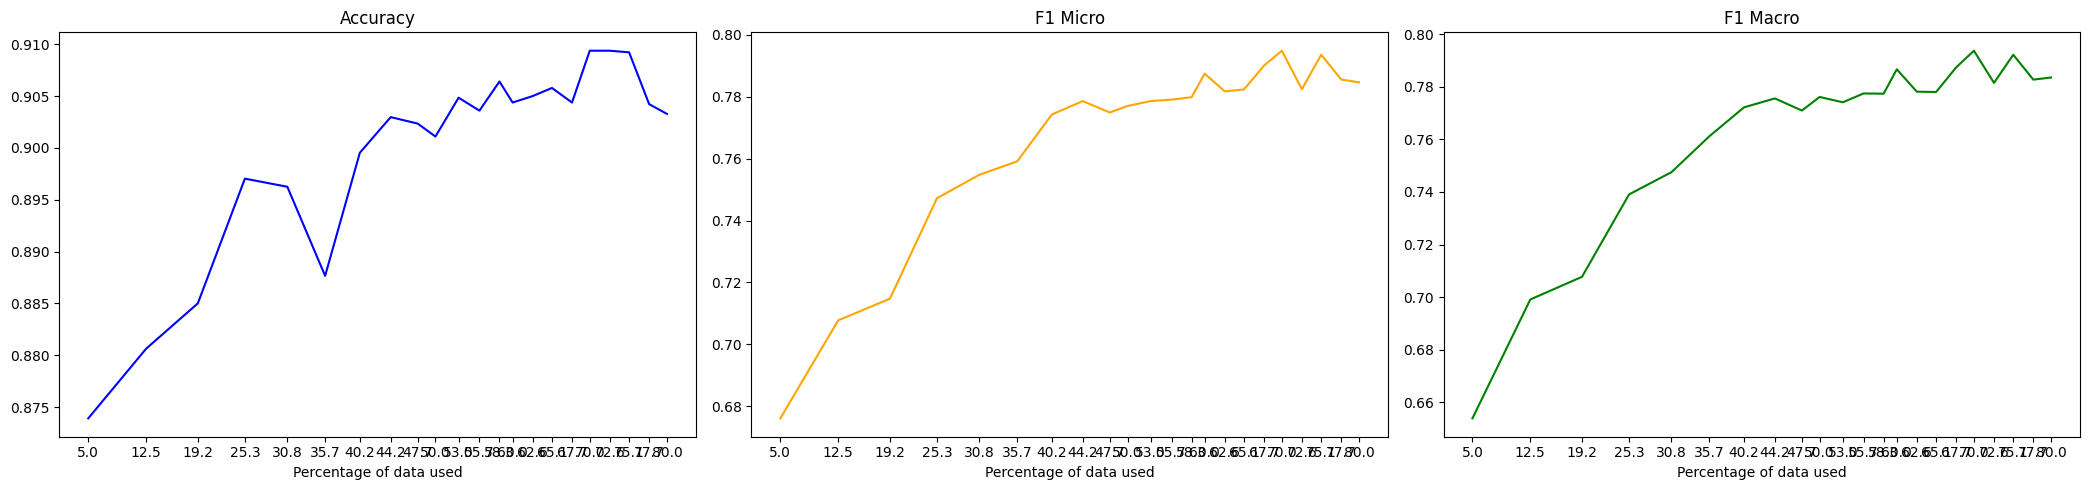

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.573, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4299, Accuracy: 0.793, F1 Micro: 0.0569, F1 Macro: 0.0488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.398, Accuracy: 0.8236, F1 Micro: 0.2957, F1 Macro: 0.2101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3572, Accuracy: 0.8389, F1 Micro: 0.4256, F1 Macro: 0.3377
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2998, Accuracy: 0.8417, F1 Micro: 0.4468, F1 Macro: 0.3645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2759, Accuracy: 0.8531, F1 Micro: 0.5406, F1 Macro: 0.4609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2245, Accuracy: 0.8637, F1 Micro: 0.6152, F1 Macro: 0.5822
Epoch 8/10, Train Loss: 0.1944, Accuracy: 0.8647, F1 Micro: 0.5957, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1747, Accuracy: 0.8687, F1 Micro: 0.643

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5581, Accuracy: 0.8333, F1 Micro: 0.4673, F1 Macro: 0.445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3905, Accuracy: 0.86, F1 Micro: 0.6161, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3003, Accuracy: 0.8684, F1 Micro: 0.6317, F1 Macro: 0.6217
Epoch 4/10, Train Loss: 0.249, Accuracy: 0.8687, F1 Micro: 0.6185, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2114, Accuracy: 0.8752, F1 Micro: 0.6678, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.16, Accuracy: 0.8766, F1 Micro: 0.6855, F1 Macro: 0.6789
Epoch 7/10, Train Loss: 0.1202, Accuracy: 0.8744, F1 Micro: 0.6579, F1 Macro: 0.6411
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.8788, F1 Micro: 0.6641, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.8778, F1 Micro: 0.7049, F1 Macro: 0.6985
Epoch 10/10, Train Loss: 0.0671, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4454, Accuracy: 0.8081, F1 Micro: 0.6067, F1 Macro: 0.607
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2428, Accuracy: 0.8636, F1 Micro: 0.6421, F1 Macro: 0.6316
Epoch 3/10, Train Loss: 0.2057, Accuracy: 0.8608, F1 Micro: 0.5846, F1 Macro: 0.5483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.8777, F1 Micro: 0.6897, F1 Macro: 0.6842
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.8788, F1 Micro: 0.6838, F1 Macro: 0.67
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.8755, F1 Micro: 0.6917, F1 Macro: 0.6803
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.8808, F1 Micro: 0.6937, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.8808, F1 Micro: 0.6947, F1 Macro: 0.6831
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.8819, F1 Micro: 0.7095, F1 Macro: 0.6956
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4614, Accuracy: 0.8558, F1 Micro: 0.6225, F1 Macro: 0.5957
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2816, Accuracy: 0.8748, F1 Micro: 0.6988, F1 Macro: 0.6984
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.8802, F1 Micro: 0.6837, F1 Macro: 0.6694
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.8819, F1 Micro: 0.6879, F1 Macro: 0.6743
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.8817, F1 Micro: 0.6755, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.8888, F1 Micro: 0.7201, F1 Macro: 0.7126
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.8852, F1 Micro: 0.7049, F1 Macro: 0.6929
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.8883, F1 Micro: 0.7291, F1 Macro: 0.7238
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.8864, F1 Micro: 0.6949, F1 Macro: 0.6828
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.8866, F1 Micro: 0.6921, F1 Macro: 0.6797
Iteration 1969: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4288, Accuracy: 0.8619, F1 Micro: 0.6229, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.8802, F1 Micro: 0.7012, F1 Macro: 0.686
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.8895, F1 Micro: 0.7248, F1 Macro: 0.7129
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.8905, F1 Micro: 0.7105, F1 Macro: 0.7029
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.888, F1 Micro: 0.7098, F1 Macro: 0.6847
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.8941, F1 Micro: 0.7392, F1 Macro: 0.728
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.89, F1 Micro: 0.7224, F1 Macro: 0.7077
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.8902, F1 Micro: 0.7115, F1 Macro: 0.6954
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.8902, F1 Micro: 0.7045, F1 Macro: 0.685
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.8938, F1 Micro: 0.7236, F1 Macro: 0.7073
Iteration 2394: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4324, Accuracy: 0.8509, F1 Micro: 0.6903, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2726, Accuracy: 0.887, F1 Micro: 0.7134, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.8906, F1 Micro: 0.7145, F1 Macro: 0.6893
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.8956, F1 Micro: 0.7362, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.8945, F1 Micro: 0.7405, F1 Macro: 0.7237
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.8941, F1 Micro: 0.7436, F1 Macro: 0.7258
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.8961, F1 Micro: 0.7403, F1 Macro: 0.7161
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.8958, F1 Micro: 0.7438, F1 Macro: 0.73
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.8956, F1 Micro: 0.7413, F1 Macro: 0.7247
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4178, Accuracy: 0.8689, F1 Micro: 0.6351, F1 Macro: 0.6095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.8908, F1 Micro: 0.7347, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.197, Accuracy: 0.8933, F1 Micro: 0.7652, F1 Macro: 0.7622
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.8986, F1 Micro: 0.743, F1 Macro: 0.733
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.8983, F1 Micro: 0.7635, F1 Macro: 0.7587
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.8986, F1 Micro: 0.7539, F1 Macro: 0.7463
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9002, F1 Micro: 0.7532, F1 Macro: 0.7423
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.8964, F1 Micro: 0.7397, F1 Macro: 0.7184
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9008, F1 Micro: 0.7507, F1 Macro: 0.7352
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.8972, F1 Micro: 0.7536, F1 Macro: 0.7479
Iteration 3122: Accuracy: 0.8933, F1 Micro: 0.7652, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4175, Accuracy: 0.8817, F1 Micro: 0.7058, F1 Macro: 0.7029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.8952, F1 Micro: 0.7424, F1 Macro: 0.7273
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.8994, F1 Micro: 0.7453, F1 Macro: 0.7279
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.8992, F1 Micro: 0.7561, F1 Macro: 0.749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9006, F1 Micro: 0.7607, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.8973, F1 Micro: 0.7676, F1 Macro: 0.762
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.8909, F1 Micro: 0.761, F1 Macro: 0.7558
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.898, F1 Micro: 0.7643, F1 Macro: 0.7575
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.8998, F1 Micro: 0.76, F1 Macro: 0.7538
Epoch 10/10, Train Loss: 0.0425, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4059, Accuracy: 0.8788, F1 Micro: 0.7074, F1 Macro: 0.706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2434, Accuracy: 0.8942, F1 Micro: 0.7211, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.8998, F1 Micro: 0.7712, F1 Macro: 0.7687
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9005, F1 Micro: 0.7416, F1 Macro: 0.731
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.8945, F1 Micro: 0.7112, F1 Macro: 0.6924
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9002, F1 Micro: 0.7481, F1 Macro: 0.7342
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.8991, F1 Micro: 0.7678, F1 Macro: 0.7604
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9003, F1 Micro: 0.7592, F1 Macro: 0.7477
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.8994, F1 Micro: 0.7453, F1 Macro: 0.7321
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.9005, F1 Micro: 0.757, F1 Macro: 0.7482
Iteration 3711: Accuracy: 0.8998, F1 Micro: 0.7712, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4079, Accuracy: 0.8811, F1 Micro: 0.7003, F1 Macro: 0.6759
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2425, Accuracy: 0.8969, F1 Micro: 0.7541, F1 Macro: 0.7425
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.8978, F1 Micro: 0.7475, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9023, F1 Micro: 0.7753, F1 Macro: 0.7719
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.8995, F1 Micro: 0.7591, F1 Macro: 0.7491
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9006, F1 Micro: 0.7589, F1 Macro: 0.7519
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.8997, F1 Micro: 0.7574, F1 Macro: 0.7501
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9009, F1 Micro: 0.7627, F1 Macro: 0.7558
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9, F1 Micro: 0.7693, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.9014, F1 Micro: 0.7555, F1 Macro: 0.7449
Iteration 3886: Accuracy: 0.9023, F1 Micro: 0.7753, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3874, Accuracy: 0.8841, F1 Micro: 0.7387, F1 Macro: 0.735
Epoch 2/10, Train Loss: 0.2364, Accuracy: 0.8967, F1 Micro: 0.7372, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9008, F1 Micro: 0.7513, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.902, F1 Micro: 0.7633, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9008, F1 Micro: 0.768, F1 Macro: 0.7629
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9011, F1 Micro: 0.7594, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9055, F1 Micro: 0.772, F1 Macro: 0.7676
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.9016, F1 Micro: 0.7606, F1 Macro: 0.7535
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.8973, F1 Micro: 0.772, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.386, Accuracy: 0.8866, F1 Micro: 0.7101, F1 Macro: 0.7027
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2406, Accuracy: 0.8956, F1 Micro: 0.7606, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9008, F1 Micro: 0.7718, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9028, F1 Micro: 0.7753, F1 Macro: 0.7714
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9006, F1 Micro: 0.7609, F1 Macro: 0.7549
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9017, F1 Micro: 0.7627, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9039, F1 Micro: 0.7801, F1 Macro: 0.778
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9045, F1 Micro: 0.7633, F1 Macro: 0.7541
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9031, F1 Micro: 0.7798, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9047, F1 Micro: 0.7681, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3791, Accuracy: 0.8839, F1 Micro: 0.7193, F1 Macro: 0.7025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.8983, F1 Micro: 0.7533, F1 Macro: 0.7436
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.898, F1 Micro: 0.7716, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9052, F1 Micro: 0.7721, F1 Macro: 0.7681
Epoch 5/10, Train Loss: 0.1278, Accuracy: 0.9087, F1 Micro: 0.7712, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9013, F1 Micro: 0.7756, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9069, F1 Micro: 0.7789, F1 Macro: 0.7784
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9089, F1 Micro: 0.775, F1 Macro: 0.7707
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9047, F1 Micro: 0.7634, F1 Macro: 0.7595
Epoch 10/10, Train Loss: 0.0343, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.8805, F1 Micro: 0.6784, F1 Macro: 0.6567
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2436, Accuracy: 0.8964, F1 Micro: 0.7429, F1 Macro: 0.7245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.9038, F1 Micro: 0.7601, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.9084, F1 Micro: 0.7794, F1 Macro: 0.7717
Epoch 5/10, Train Loss: 0.107, Accuracy: 0.8998, F1 Micro: 0.7685, F1 Macro: 0.7625
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9055, F1 Micro: 0.7699, F1 Macro: 0.7652
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9041, F1 Micro: 0.7676, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9056, F1 Micro: 0.7794, F1 Macro: 0.7731
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9008, F1 Micro: 0.7759, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0352, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3828, Accuracy: 0.8875, F1 Micro: 0.7243, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2442, Accuracy: 0.9, F1 Micro: 0.7746, F1 Macro: 0.7721
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9034, F1 Micro: 0.7701, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.903, F1 Micro: 0.7765, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9048, F1 Micro: 0.7768, F1 Macro: 0.7696
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9064, F1 Micro: 0.7706, F1 Macro: 0.7616
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.903, F1 Micro: 0.7569, F1 Macro: 0.7467
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9025, F1 Micro: 0.7682, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9025, F1 Micro: 0.7817, F1 Macro: 0.78
Epoch 10/10, Train Loss: 0.0354, Accuracy: 0.9017, F1 Micro: 0.7657, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.8905, F1 Micro: 0.733, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2303, Accuracy: 0.8988, F1 Micro: 0.7677, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9039, F1 Micro: 0.7803, F1 Macro: 0.7763
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.907, F1 Micro: 0.7761, F1 Macro: 0.7712
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9047, F1 Micro: 0.7619, F1 Macro: 0.7527
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9089, F1 Micro: 0.7804, F1 Macro: 0.7743
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9052, F1 Micro: 0.7741, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.907, F1 Micro: 0.7726, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9061, F1 Micro: 0.7719, F1 Macro: 0.7677
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9067, F1 Micro: 0.7708, F1 Macro: 0.7664
Iteration 5063: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3749, Accuracy: 0.8928, F1 Micro: 0.75, F1 Macro: 0.7441
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.9019, F1 Micro: 0.7579, F1 Macro: 0.7467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.9056, F1 Micro: 0.7778, F1 Macro: 0.7705
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.908, F1 Micro: 0.7739, F1 Macro: 0.7644
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.907, F1 Micro: 0.775, F1 Macro: 0.7695
Epoch 6/10, Train Loss: 0.082, Accuracy: 0.9067, F1 Micro: 0.7755, F1 Macro: 0.7688
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9053, F1 Micro: 0.7683, F1 Macro: 0.7611
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9041, F1 Micro: 0.7796, F1 Macro: 0.778
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9034, F1 Micro: 0.7788, F1 Macro: 0.7768
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9036, F1 Micro: 0.7726, F1 Macro: 0.7669
Iteration 5263: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3679, Accuracy: 0.8889, F1 Micro: 0.743, F1 Macro: 0.7393
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.239, Accuracy: 0.8995, F1 Micro: 0.7554, F1 Macro: 0.7472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.9047, F1 Micro: 0.7682, F1 Macro: 0.7628
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9016, F1 Micro: 0.7623, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9003, F1 Micro: 0.7771, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9038, F1 Micro: 0.7831, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.9052, F1 Micro: 0.7884, F1 Macro: 0.7886
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9009, F1 Micro: 0.7627, F1 Macro: 0.7501
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9041, F1 Micro: 0.7804, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0294, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3723, Accuracy: 0.8898, F1 Micro: 0.7419, F1 Macro: 0.7282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.8978, F1 Micro: 0.7728, F1 Macro: 0.7703
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9031, F1 Micro: 0.7571, F1 Macro: 0.7447
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9072, F1 Micro: 0.7895, F1 Macro: 0.7888
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.9066, F1 Micro: 0.7752, F1 Macro: 0.7666
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9008, F1 Micro: 0.7741, F1 Macro: 0.7726
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9058, F1 Micro: 0.7764, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0455, Accuracy: 0.9053, F1 Micro: 0.78, F1 Macro: 0.7804
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9041, F1 Micro: 0.7697, F1 Macro: 0.7607
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.905, F1 Micro: 0.7827, F1 Macro: 0.7814
Iteration 5641: Accuracy: 0.9072, F1 Micro: 0.7895, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3647, Accuracy: 0.8866, F1 Micro: 0.6863, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.9002, F1 Micro: 0.7568, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9033, F1 Micro: 0.7779, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9077, F1 Micro: 0.7872, F1 Macro: 0.7838
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9016, F1 Micro: 0.7826, F1 Macro: 0.7813
Epoch 6/10, Train Loss: 0.0843, Accuracy: 0.9036, F1 Micro: 0.7664, F1 Macro: 0.7596
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9059, F1 Micro: 0.7742, F1 Macro: 0.7702
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9047, F1 Micro: 0.7686, F1 Macro: 0.7607
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9045, F1 Micro: 0.7801, F1 Macro: 0.7765
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.9034, F1 Micro: 0.7771, F1 Macro: 0.7717
Iteration 5841: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.8914, F1 Micro: 0.7309, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.9008, F1 Micro: 0.7503, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.9084, F1 Micro: 0.7904, F1 Macro: 0.7872
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9067, F1 Micro: 0.7721, F1 Macro: 0.7665
Epoch 5/10, Train Loss: 0.1117, Accuracy: 0.9036, F1 Micro: 0.7866, F1 Macro: 0.7863
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.8995, F1 Micro: 0.7762, F1 Macro: 0.7771
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9023, F1 Micro: 0.7808, F1 Macro: 0.7769
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9045, F1 Micro: 0.7837, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.905, F1 Micro: 0.78, F1 Macro: 0.776
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.9055, F1 Micro: 0.7711, F1 Macro: 0.7643
Iteration 6041: Accuracy: 0.9084, F1 Micro: 0.7904, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.355, Accuracy: 0.8905, F1 Micro: 0.7452, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2328, Accuracy: 0.9011, F1 Micro: 0.7712, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9053, F1 Micro: 0.779, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9069, F1 Micro: 0.7831, F1 Macro: 0.7765
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9055, F1 Micro: 0.7791, F1 Macro: 0.7728
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9027, F1 Micro: 0.7752, F1 Macro: 0.7708
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.9086, F1 Micro: 0.7788, F1 Macro: 0.7705
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9009, F1 Micro: 0.7745, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9034, F1 Micro: 0.7751, F1 Macro: 0.7712
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.903, F1 Micro: 0.7765, F1 Macro: 0.7712
Iteration 6218: Accura

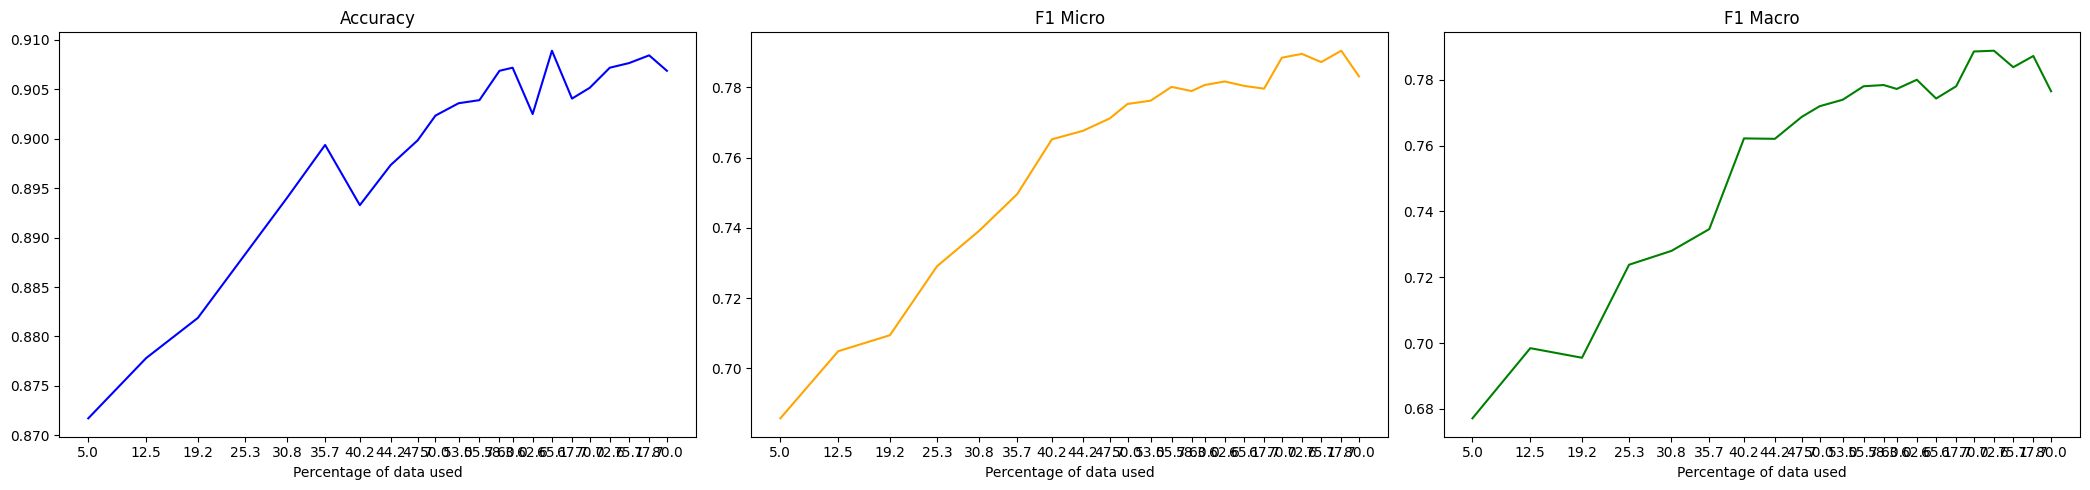

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6187, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4493, Accuracy: 0.7884, F1 Micro: 0.016, F1 Macro: 0.0144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4203, Accuracy: 0.8111, F1 Micro: 0.2051, F1 Macro: 0.1483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3885, Accuracy: 0.8291, F1 Micro: 0.3587, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3558, Accuracy: 0.8389, F1 Micro: 0.4418, F1 Macro: 0.3567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2968, Accuracy: 0.855, F1 Micro: 0.5455, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2508, Accuracy: 0.8719, F1 Micro: 0.6664, F1 Macro: 0.6505
Epoch 8/10, Train Loss: 0.2154, Accuracy: 0.8605, F1 Micro: 0.5802, F1 Macro: 0.5478
Epoch 9/10, Train Loss: 0.1636, Accuracy: 0.867, F1 Micro: 0.6343, F1 Macro: 0.6221
Higher F1 achie

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4563, Accuracy: 0.8037, F1 Micro: 0.3298, F1 Macro: 0.1758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.8267, F1 Micro: 0.3418, F1 Macro: 0.2104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.8347, F1 Micro: 0.394, F1 Macro: 0.3014
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.8559, F1 Micro: 0.5917, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.8644, F1 Micro: 0.609, F1 Macro: 0.5726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.8734, F1 Micro: 0.6939, F1 Macro: 0.6783
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.87, F1 Micro: 0.6683, F1 Macro: 0.6463
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.8702, F1 Micro: 0.6593, F1 Macro: 0.6407
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.8742, F1 Micro: 0.6812, F1 Macro: 0.6689
Epoch 10/10, Train Loss: 0.0387, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4733, Accuracy: 0.7986, F1 Micro: 0.5758, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3, Accuracy: 0.8587, F1 Micro: 0.6268, F1 Macro: 0.6322
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2353, Accuracy: 0.8666, F1 Micro: 0.6328, F1 Macro: 0.6339
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2053, Accuracy: 0.8753, F1 Micro: 0.6644, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.8736, F1 Micro: 0.7196, F1 Macro: 0.7205
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.8764, F1 Micro: 0.6615, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.883, F1 Micro: 0.7084, F1 Macro: 0.7022
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.8805, F1 Micro: 0.6994, F1 Macro: 0.6891
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.8831, F1 Micro: 0.7029, F1 Macro: 0.7005
Epoch 10/10, Train Loss: 0.0514, Accuracy: 0.8806, F1 Micro: 0.7002, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4399, Accuracy: 0.82, F1 Micro: 0.6049, F1 Macro: 0.6186
Epoch 2/10, Train Loss: 0.2763, Accuracy: 0.86, F1 Micro: 0.6035, F1 Macro: 0.5915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.882, F1 Micro: 0.7102, F1 Macro: 0.6991
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.8817, F1 Micro: 0.681, F1 Macro: 0.6485
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.8828, F1 Micro: 0.6806, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.8886, F1 Micro: 0.7147, F1 Macro: 0.6955
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.8866, F1 Micro: 0.7119, F1 Macro: 0.692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.8894, F1 Micro: 0.7234, F1 Macro: 0.7079
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.885, F1 Micro: 0.7199, F1 Macro: 0.7094
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.8872, F1 Micro: 0.7225, F1 Macro: 0.7087
Iteration 1969: Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4458, Accuracy: 0.8414, F1 Micro: 0.5137, F1 Macro: 0.4243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2735, Accuracy: 0.8794, F1 Micro: 0.6951, F1 Macro: 0.682
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2276, Accuracy: 0.8925, F1 Micro: 0.7304, F1 Macro: 0.7272
Epoch 4/10, Train Loss: 0.1894, Accuracy: 0.8908, F1 Micro: 0.7169, F1 Macro: 0.6982
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.8861, F1 Micro: 0.6943, F1 Macro: 0.6741
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.8903, F1 Micro: 0.7153, F1 Macro: 0.6944
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.8944, F1 Micro: 0.7322, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.8969, F1 Micro: 0.7504, F1 Macro: 0.7389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.8986, F1 Micro: 0.7512, F1 Macro: 0.736
Epoch 10/10, Train Loss: 0.0354, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4214, Accuracy: 0.8308, F1 Micro: 0.6427, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2494, Accuracy: 0.8795, F1 Micro: 0.7222, F1 Macro: 0.7141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.8913, F1 Micro: 0.735, F1 Macro: 0.7203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.8934, F1 Micro: 0.7531, F1 Macro: 0.7483
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.8956, F1 Micro: 0.7298, F1 Macro: 0.7087
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.8913, F1 Micro: 0.7292, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.8984, F1 Micro: 0.754, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.8972, F1 Micro: 0.7678, F1 Macro: 0.7629
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.8978, F1 Micro: 0.7441, F1 Macro: 0.7273
Epoch 10/10, Train Loss: 0.0394, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4285, Accuracy: 0.8622, F1 Micro: 0.6944, F1 Macro: 0.6862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.8936, F1 Micro: 0.7441, F1 Macro: 0.7381
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.8923, F1 Micro: 0.7207, F1 Macro: 0.6994
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.8988, F1 Micro: 0.7372, F1 Macro: 0.7187
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9002, F1 Micro: 0.7602, F1 Macro: 0.7532
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.8956, F1 Micro: 0.7343, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.8973, F1 Micro: 0.7624, F1 Macro: 0.7558
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.8902, F1 Micro: 0.7567, F1 Macro: 0.7517
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.8983, F1 Micro: 0.7497, F1 Macro: 0.7362
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.8967, F1 Micro: 0.756, F1 Macro: 0.7477
Iteration 3122: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4186, Accuracy: 0.8709, F1 Micro: 0.7146, F1 Macro: 0.7147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.8934, F1 Micro: 0.7415, F1 Macro: 0.73
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.8994, F1 Micro: 0.7473, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9, F1 Micro: 0.7746, F1 Macro: 0.7729
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.8988, F1 Micro: 0.7366, F1 Macro: 0.7183
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9008, F1 Micro: 0.7599, F1 Macro: 0.7524
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.8986, F1 Micro: 0.7503, F1 Macro: 0.7397
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9006, F1 Micro: 0.7622, F1 Macro: 0.753
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.8995, F1 Micro: 0.7654, F1 Macro: 0.7563
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.8991, F1 Micro: 0.7584, F1 Macro: 0.7548
Iteration 3432: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4098, Accuracy: 0.8791, F1 Micro: 0.6906, F1 Macro: 0.6746
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.8903, F1 Micro: 0.7219, F1 Macro: 0.6961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.8995, F1 Micro: 0.7701, F1 Macro: 0.7663
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9042, F1 Micro: 0.7619, F1 Macro: 0.7535
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.8953, F1 Micro: 0.7335, F1 Macro: 0.7158
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.898, F1 Micro: 0.7466, F1 Macro: 0.733
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.8972, F1 Micro: 0.7477, F1 Macro: 0.7295
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9013, F1 Micro: 0.7663, F1 Macro: 0.7615
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.8981, F1 Micro: 0.7498, F1 Macro: 0.7369
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.8994, F1 Micro: 0.7583, F1 Macro: 0.7498
Iteration 3711: Accuracy: 0.8995, F1 Micro: 0.7701, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.409, Accuracy: 0.8783, F1 Micro: 0.6558, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.8952, F1 Micro: 0.7557, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1968, Accuracy: 0.8998, F1 Micro: 0.768, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9038, F1 Micro: 0.773, F1 Macro: 0.768
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.8995, F1 Micro: 0.7457, F1 Macro: 0.7281
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9003, F1 Micro: 0.7623, F1 Macro: 0.7517
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9008, F1 Micro: 0.7559, F1 Macro: 0.75
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.8992, F1 Micro: 0.7628, F1 Macro: 0.7588
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.8964, F1 Micro: 0.7679, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.8994, F1 Micro: 0.757, F1 Macro: 0.7527
Iteration 3886: Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8839, F1 Micro: 0.7197, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.8967, F1 Micro: 0.7611, F1 Macro: 0.757
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9016, F1 Micro: 0.7599, F1 Macro: 0.7515
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.9033, F1 Micro: 0.7566, F1 Macro: 0.7421
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9016, F1 Micro: 0.7506, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9041, F1 Micro: 0.7653, F1 Macro: 0.7577
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.9005, F1 Micro: 0.7524, F1 Macro: 0.7417
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9027, F1 Micro: 0.7666, F1 Macro: 0.7564
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9034, F1 Micro: 0.7586, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9038, F1 Micro: 0.7698, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3944, Accuracy: 0.8823, F1 Micro: 0.7271, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2328, Accuracy: 0.8989, F1 Micro: 0.7583, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9027, F1 Micro: 0.7742, F1 Macro: 0.7713
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9003, F1 Micro: 0.7574, F1 Macro: 0.7484
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9033, F1 Micro: 0.7533, F1 Macro: 0.7423
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9014, F1 Micro: 0.7793, F1 Macro: 0.7806
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.8975, F1 Micro: 0.77, F1 Macro: 0.769
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9027, F1 Micro: 0.7729, F1 Macro: 0.7695
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9014, F1 Micro: 0.7689, F1 Macro: 0.7663
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9034, F1 Micro: 0.7761, F1 Macro: 0.7757
Iteration 4330: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3876, Accuracy: 0.8856, F1 Micro: 0.7002, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2247, Accuracy: 0.8978, F1 Micro: 0.7403, F1 Macro: 0.7341
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.9016, F1 Micro: 0.7649, F1 Macro: 0.7616
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.8978, F1 Micro: 0.7423, F1 Macro: 0.725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.8986, F1 Micro: 0.7686, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9019, F1 Micro: 0.7746, F1 Macro: 0.7707
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9025, F1 Micro: 0.768, F1 Macro: 0.7571
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.8948, F1 Micro: 0.7738, F1 Macro: 0.7786
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.902, F1 Micro: 0.768, F1 Macro: 0.7596
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9019, F1 Micro: 0.7679, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3923, Accuracy: 0.8841, F1 Micro: 0.7284, F1 Macro: 0.7142
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2288, Accuracy: 0.8936, F1 Micro: 0.7427, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.9025, F1 Micro: 0.7553, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9023, F1 Micro: 0.773, F1 Macro: 0.7675
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9013, F1 Micro: 0.7577, F1 Macro: 0.7468
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9025, F1 Micro: 0.7721, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.8984, F1 Micro: 0.7662, F1 Macro: 0.762
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.8981, F1 Micro: 0.7643, F1 Macro: 0.7587
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9002, F1 Micro: 0.7611, F1 Macro: 0.7553
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9019, F1 Micro: 0.7678, F1 Macro: 0.7628
Iteration 4663: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3789, Accuracy: 0.8891, F1 Micro: 0.7366, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2324, Accuracy: 0.8975, F1 Micro: 0.7552, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1853, Accuracy: 0.903, F1 Micro: 0.764, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9055, F1 Micro: 0.7801, F1 Macro: 0.7715
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9022, F1 Micro: 0.7596, F1 Macro: 0.7479
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9019, F1 Micro: 0.7665, F1 Macro: 0.7627
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.9025, F1 Micro: 0.7733, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.9017, F1 Micro: 0.765, F1 Macro: 0.757
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9017, F1 Micro: 0.7687, F1 Macro: 0.7623
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9016, F1 Micro: 0.7764, F1 Macro: 0.7728
Iteration 4863: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8828, F1 Micro: 0.6733, F1 Macro: 0.6611
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2305, Accuracy: 0.8997, F1 Micro: 0.7517, F1 Macro: 0.7456
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1904, Accuracy: 0.9062, F1 Micro: 0.7815, F1 Macro: 0.7802
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9061, F1 Micro: 0.7679, F1 Macro: 0.7597
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9019, F1 Micro: 0.7585, F1 Macro: 0.7532
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9067, F1 Micro: 0.7706, F1 Macro: 0.7632
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.905, F1 Micro: 0.7678, F1 Macro: 0.7591
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.9044, F1 Micro: 0.7771, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9008, F1 Micro: 0.7695, F1 Macro: 0.7606
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9017, F1 Micro: 0.7622, F1 Macro: 0.7567
Iteration 5063: Accuracy: 0.9062, F1 Micro: 0.7815,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3687, Accuracy: 0.89, F1 Micro: 0.7345, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2343, Accuracy: 0.9011, F1 Micro: 0.7628, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.9041, F1 Micro: 0.7788, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.907, F1 Micro: 0.7877, F1 Macro: 0.7864
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9017, F1 Micro: 0.7714, F1 Macro: 0.7685
Epoch 6/10, Train Loss: 0.082, Accuracy: 0.9023, F1 Micro: 0.7736, F1 Macro: 0.7706
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.9047, F1 Micro: 0.7834, F1 Macro: 0.7794
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.8989, F1 Micro: 0.7596, F1 Macro: 0.748
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9017, F1 Micro: 0.764, F1 Macro: 0.7571
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9064, F1 Micro: 0.772, F1 Macro: 0.7601
Iteration 5263: Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3683, Accuracy: 0.8886, F1 Micro: 0.7147, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.229, Accuracy: 0.9017, F1 Micro: 0.775, F1 Macro: 0.7725
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.9014, F1 Micro: 0.7457, F1 Macro: 0.7366
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9041, F1 Micro: 0.7611, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9073, F1 Micro: 0.7765, F1 Macro: 0.7663
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9031, F1 Micro: 0.7702, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9033, F1 Micro: 0.7769, F1 Macro: 0.7761
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.8991, F1 Micro: 0.7727, F1 Macro: 0.77
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9023, F1 Micro: 0.7686, F1 Macro: 0.767
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9059, F1 Micro: 0.7737, F1 Macro: 0.7695
Iteration 5441: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3671, Accuracy: 0.8886, F1 Micro: 0.7282, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2282, Accuracy: 0.9006, F1 Micro: 0.7686, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1872, Accuracy: 0.9059, F1 Micro: 0.7816, F1 Macro: 0.7758
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9017, F1 Micro: 0.7649, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.9072, F1 Micro: 0.7863, F1 Macro: 0.784
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9067, F1 Micro: 0.7745, F1 Macro: 0.7708
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9058, F1 Micro: 0.7749, F1 Macro: 0.7686
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9048, F1 Micro: 0.7835, F1 Macro: 0.7852
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9034, F1 Micro: 0.7836, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9059, F1 Micro: 0.7876, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3694, Accuracy: 0.8875, F1 Micro: 0.7145, F1 Macro: 0.7021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.9002, F1 Micro: 0.7549, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9041, F1 Micro: 0.7676, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9052, F1 Micro: 0.7857, F1 Macro: 0.7828
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9028, F1 Micro: 0.7785, F1 Macro: 0.7789
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.908, F1 Micro: 0.7827, F1 Macro: 0.7794
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9061, F1 Micro: 0.7811, F1 Macro: 0.7771
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9028, F1 Micro: 0.7758, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9044, F1 Micro: 0.7827, F1 Macro: 0.7815
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9062, F1 Micro: 0.7669, F1 Macro: 0.7587
Iteration 5841: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3589, Accuracy: 0.8911, F1 Micro: 0.7536, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9016, F1 Micro: 0.7633, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.9002, F1 Micro: 0.7827, F1 Macro: 0.7851
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9061, F1 Micro: 0.7809, F1 Macro: 0.7782
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.902, F1 Micro: 0.7813, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.898, F1 Micro: 0.7747, F1 Macro: 0.7729
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9059, F1 Micro: 0.7708, F1 Macro: 0.7645
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.9047, F1 Micro: 0.7752, F1 Macro: 0.77
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9009, F1 Micro: 0.7696, F1 Macro: 0.7638
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9034, F1 Micro: 0.7796, F1 Macro: 0.7776
Iteration 6041: Accuracy: 0.9002, F1 Micro: 0.7827, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3617, Accuracy: 0.8889, F1 Micro: 0.7143, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2318, Accuracy: 0.9023, F1 Micro: 0.7577, F1 Macro: 0.7465
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.8989, F1 Micro: 0.7419, F1 Macro: 0.7253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9031, F1 Micro: 0.7655, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9047, F1 Micro: 0.7672, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9058, F1 Micro: 0.7841, F1 Macro: 0.7804
Epoch 7/10, Train Loss: 0.0629, Accuracy: 0.9067, F1 Micro: 0.7835, F1 Macro: 0.7792
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9033, F1 Micro: 0.7788, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9047, F1 Micro: 0.782, F1 Macro: 0.7795
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9003, F1 Micro: 0.7824, F1 

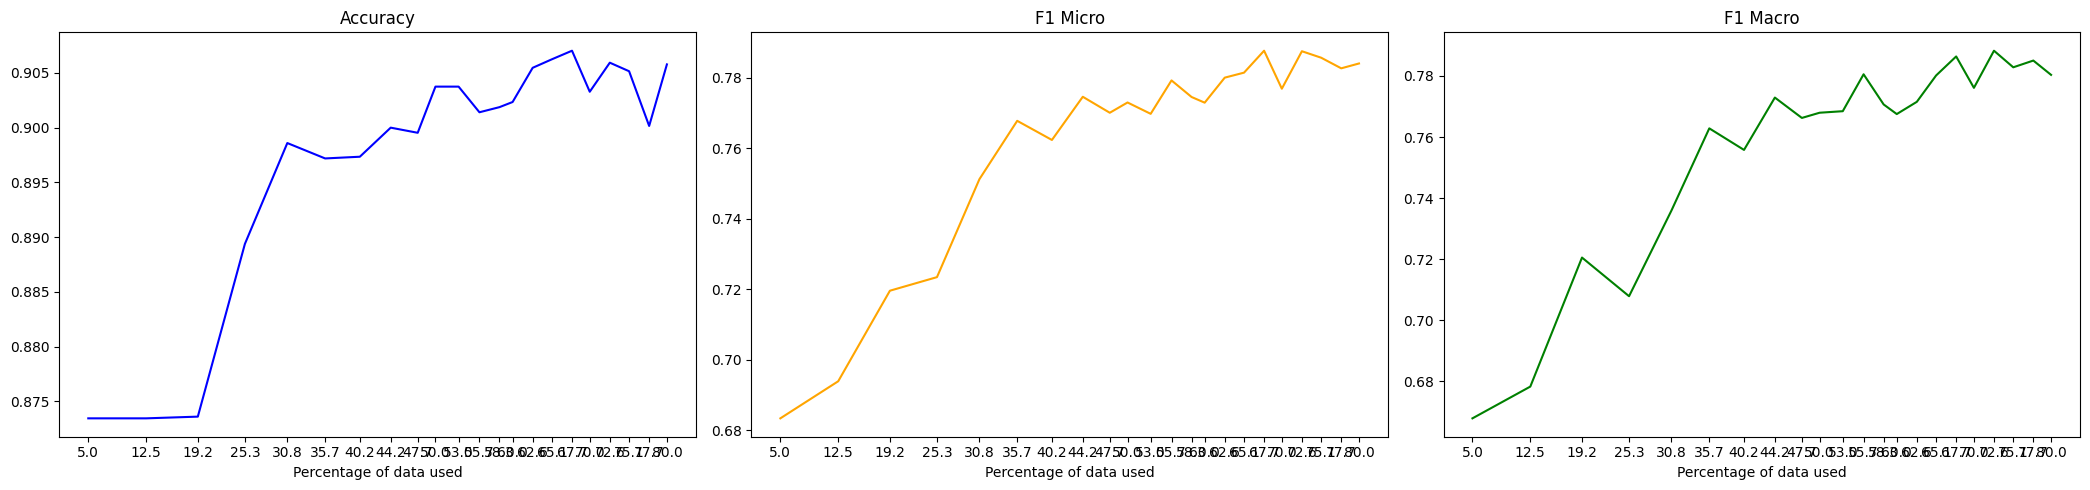

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5896, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4953, Accuracy: 0.79, F1 Micro: 0.0303, F1 Macro: 0.0269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4288, Accuracy: 0.8306, F1 Micro: 0.3593, F1 Macro: 0.2395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3915, Accuracy: 0.835, F1 Micro: 0.4413, F1 Macro: 0.3366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3345, Accuracy: 0.8445, F1 Micro: 0.4826, F1 Macro: 0.381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2887, Accuracy: 0.8612, F1 Micro: 0.6162, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2536, Accuracy: 0.8698, F1 Micro: 0.6548, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2078, Accuracy: 0.8711, F1 Micro: 0.6642, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1918, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4284, Accuracy: 0.7887, F1 Micro: 0.3247, F1 Macro: 0.1614
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2386, Accuracy: 0.828, F1 Micro: 0.3535, F1 Macro: 0.2211
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.8391, F1 Micro: 0.4707, F1 Macro: 0.3592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.848, F1 Micro: 0.5195, F1 Macro: 0.4611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.872, F1 Micro: 0.6858, F1 Macro: 0.674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.8777, F1 Micro: 0.6911, F1 Macro: 0.6682
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.8739, F1 Micro: 0.6689, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.8717, F1 Micro: 0.7061, F1 Macro: 0.697
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.8695, F1 Micro: 0.6355, F1 Macro: 0.5928
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4721, Accuracy: 0.772, F1 Micro: 0.5765, F1 Macro: 0.5972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.287, Accuracy: 0.8459, F1 Micro: 0.6386, F1 Macro: 0.6418
Epoch 3/10, Train Loss: 0.2516, Accuracy: 0.8517, F1 Micro: 0.5977, F1 Macro: 0.5785
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2175, Accuracy: 0.868, F1 Micro: 0.6478, F1 Macro: 0.6305
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.8784, F1 Micro: 0.6963, F1 Macro: 0.6833
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.8816, F1 Micro: 0.685, F1 Macro: 0.6671
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.8772, F1 Micro: 0.6823, F1 Macro: 0.67
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.8803, F1 Micro: 0.6958, F1 Macro: 0.6767
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.8783, F1 Micro: 0.6895, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.8848, F1 Micro: 0.701, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4278, Accuracy: 0.8248, F1 Micro: 0.5992, F1 Macro: 0.6064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.8589, F1 Micro: 0.656, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.8819, F1 Micro: 0.686, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.8839, F1 Micro: 0.709, F1 Macro: 0.683
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.8836, F1 Micro: 0.6879, F1 Macro: 0.6535
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.8842, F1 Micro: 0.6875, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.8878, F1 Micro: 0.72, F1 Macro: 0.703
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.8909, F1 Micro: 0.7386, F1 Macro: 0.7261
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.8939, F1 Micro: 0.7313, F1 Macro: 0.7175
Epoch 10/10, Train Loss: 0.0391, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4333, Accuracy: 0.8531, F1 Micro: 0.5719, F1 Macro: 0.5094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.8802, F1 Micro: 0.725, F1 Macro: 0.7227
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.8872, F1 Micro: 0.7103, F1 Macro: 0.695
Epoch 4/10, Train Loss: 0.1908, Accuracy: 0.8914, F1 Micro: 0.7245, F1 Macro: 0.7138
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.8933, F1 Micro: 0.7329, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.892, F1 Micro: 0.7409, F1 Macro: 0.7261
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.8877, F1 Micro: 0.6942, F1 Macro: 0.6653
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.8936, F1 Micro: 0.7281, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.8942, F1 Micro: 0.7506, F1 Macro: 0.7455
Epoch 10/10, Train Loss: 0.0402, Accuracy: 0.893, F1 Micro: 0.7497, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4102, Accuracy: 0.8536, F1 Micro: 0.6497, F1 Macro: 0.6574
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.8806, F1 Micro: 0.6961, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.8906, F1 Micro: 0.738, F1 Macro: 0.726
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.8903, F1 Micro: 0.7361, F1 Macro: 0.7268
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.8911, F1 Micro: 0.7324, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.8942, F1 Micro: 0.7543, F1 Macro: 0.7493
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.8888, F1 Micro: 0.7541, F1 Macro: 0.7542
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.8973, F1 Micro: 0.7482, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.8922, F1 Micro: 0.7555, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0357, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4201, Accuracy: 0.8636, F1 Micro: 0.6409, F1 Macro: 0.6365
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.8842, F1 Micro: 0.7447, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2149, Accuracy: 0.8917, F1 Micro: 0.7479, F1 Macro: 0.7396
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.8948, F1 Micro: 0.7384, F1 Macro: 0.7324
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.892, F1 Micro: 0.7146, F1 Macro: 0.6934
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.8995, F1 Micro: 0.7584, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9033, F1 Micro: 0.7679, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.8991, F1 Micro: 0.7691, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9006, F1 Micro: 0.7529, F1 Macro: 0.7429
Epoch 10/10, Train Loss: 0.0397, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4036, Accuracy: 0.8637, F1 Micro: 0.6409, F1 Macro: 0.6346
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2442, Accuracy: 0.89, F1 Micro: 0.7141, F1 Macro: 0.7056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.8947, F1 Micro: 0.7249, F1 Macro: 0.7128
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.898, F1 Micro: 0.7529, F1 Macro: 0.7454
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.8978, F1 Micro: 0.7704, F1 Macro: 0.7695
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.8988, F1 Micro: 0.7477, F1 Macro: 0.7442
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.8998, F1 Micro: 0.7495, F1 Macro: 0.7371
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.8991, F1 Micro: 0.7591, F1 Macro: 0.7552
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9011, F1 Micro: 0.768, F1 Macro: 0.7644
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9008, F1 Micro: 0.7646, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3902, Accuracy: 0.8716, F1 Micro: 0.6935, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.245, Accuracy: 0.8934, F1 Micro: 0.7496, F1 Macro: 0.7428
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.8955, F1 Micro: 0.7338, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.8988, F1 Micro: 0.7545, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9014, F1 Micro: 0.7587, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9017, F1 Micro: 0.7589, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9036, F1 Micro: 0.7669, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.8972, F1 Micro: 0.7691, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9047, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.8811, F1 Micro: 0.7065, F1 Macro: 0.6916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2376, Accuracy: 0.8952, F1 Micro: 0.742, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.8967, F1 Micro: 0.7421, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.8998, F1 Micro: 0.7463, F1 Macro: 0.7404
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9002, F1 Micro: 0.765, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.8997, F1 Micro: 0.7722, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9045, F1 Micro: 0.7787, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9013, F1 Micro: 0.7746, F1 Macro: 0.7721
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.8984, F1 Micro: 0.7532, F1 Macro: 0.7449
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3792, Accuracy: 0.8809, F1 Micro: 0.7078, F1 Macro: 0.7086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2409, Accuracy: 0.8983, F1 Micro: 0.7575, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.898, F1 Micro: 0.7611, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.8997, F1 Micro: 0.7671, F1 Macro: 0.762
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9005, F1 Micro: 0.7487, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9011, F1 Micro: 0.7727, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.8997, F1 Micro: 0.7783, F1 Macro: 0.7805
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.8994, F1 Micro: 0.7409, F1 Macro: 0.7299
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9036, F1 Micro: 0.7732, F1 Macro: 0.7699
Epoch 10/10, Train Loss: 0.0334, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3807, Accuracy: 0.8831, F1 Micro: 0.7196, F1 Macro: 0.7171
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2317, Accuracy: 0.8972, F1 Micro: 0.7541, F1 Macro: 0.7491
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.8989, F1 Micro: 0.7462, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9022, F1 Micro: 0.7671, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9062, F1 Micro: 0.7691, F1 Macro: 0.7606
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9039, F1 Micro: 0.7689, F1 Macro: 0.7683
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.902, F1 Micro: 0.7481, F1 Macro: 0.7411
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9055, F1 Micro: 0.7788, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9064, F1 Micro: 0.781, F1 Macro: 0.7806
Epoch 10/10, Train Loss: 0.0334, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3842, Accuracy: 0.8864, F1 Micro: 0.7166, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2278, Accuracy: 0.8984, F1 Micro: 0.7545, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.9016, F1 Micro: 0.7556, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9009, F1 Micro: 0.7625, F1 Macro: 0.7588
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.9005, F1 Micro: 0.7577, F1 Macro: 0.7513
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.9002, F1 Micro: 0.7593, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9017, F1 Micro: 0.7685, F1 Macro: 0.7636
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9005, F1 Micro: 0.7683, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9005, F1 Micro: 0.7763, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0327, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3758, Accuracy: 0.885, F1 Micro: 0.7328, F1 Macro: 0.7269
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.897, F1 Micro: 0.7566, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1867, Accuracy: 0.9013, F1 Micro: 0.7593, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9033, F1 Micro: 0.7654, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9073, F1 Micro: 0.7795, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9064, F1 Micro: 0.7827, F1 Macro: 0.7817
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9038, F1 Micro: 0.7703, F1 Macro: 0.7652
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9052, F1 Micro: 0.7763, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9062, F1 Micro: 0.7832, F1 Macro: 0.7819
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.8838, F1 Micro: 0.7123, F1 Macro: 0.6949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.8998, F1 Micro: 0.7618, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.8978, F1 Micro: 0.7715, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9059, F1 Micro: 0.7836, F1 Macro: 0.7831
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.8995, F1 Micro: 0.7353, F1 Macro: 0.7295
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.905, F1 Micro: 0.7672, F1 Macro: 0.7626
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.9039, F1 Micro: 0.7713, F1 Macro: 0.7626
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9056, F1 Micro: 0.7758, F1 Macro: 0.7726
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9031, F1 Micro: 0.7685, F1 Macro: 0.7631
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9059, F1 Micro: 0.7704, F1 Macro: 0.7637
Iteration 4863: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3707, Accuracy: 0.8881, F1 Micro: 0.7248, F1 Macro: 0.7136
Epoch 2/10, Train Loss: 0.2283, Accuracy: 0.8945, F1 Micro: 0.7172, F1 Macro: 0.6953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.9016, F1 Micro: 0.7712, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9055, F1 Micro: 0.7799, F1 Macro: 0.7751
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9056, F1 Micro: 0.7781, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9044, F1 Micro: 0.7842, F1 Macro: 0.7813
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.905, F1 Micro: 0.7783, F1 Macro: 0.7754
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9045, F1 Micro: 0.7787, F1 Macro: 0.7747
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9048, F1 Micro: 0.7639, F1 Macro: 0.7519
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9039, F1 Micro: 0.7784, F1 Macro: 0.7735
Iteration 5063: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3708, Accuracy: 0.888, F1 Micro: 0.7474, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2339, Accuracy: 0.902, F1 Micro: 0.7673, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1884, Accuracy: 0.9052, F1 Micro: 0.7841, F1 Macro: 0.7826
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9052, F1 Micro: 0.7769, F1 Macro: 0.7765
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9059, F1 Micro: 0.7787, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.905, F1 Micro: 0.7855, F1 Macro: 0.7842
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.907, F1 Micro: 0.7782, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.9023, F1 Micro: 0.756, F1 Macro: 0.7457
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9075, F1 Micro: 0.7803, F1 Macro: 0.7777
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9052, F1 Micro: 0.7878, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3667, Accuracy: 0.8867, F1 Micro: 0.7415, F1 Macro: 0.74
Epoch 2/10, Train Loss: 0.2334, Accuracy: 0.8964, F1 Micro: 0.7378, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.9025, F1 Micro: 0.7673, F1 Macro: 0.7592
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9053, F1 Micro: 0.7655, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9034, F1 Micro: 0.7759, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9067, F1 Micro: 0.7808, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9052, F1 Micro: 0.7816, F1 Macro: 0.779
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9073, F1 Micro: 0.7736, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9053, F1 Micro: 0.7801, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9047, F1 Micro: 0.7715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.8909, F1 Micro: 0.7413, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2299, Accuracy: 0.9014, F1 Micro: 0.7678, F1 Macro: 0.7595
Epoch 3/10, Train Loss: 0.189, Accuracy: 0.9003, F1 Micro: 0.744, F1 Macro: 0.724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.9039, F1 Micro: 0.7779, F1 Macro: 0.7683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1096, Accuracy: 0.9028, F1 Micro: 0.7833, F1 Macro: 0.7831
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9025, F1 Micro: 0.7765, F1 Macro: 0.7719
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.9034, F1 Micro: 0.755, F1 Macro: 0.7431
Epoch 8/10, Train Loss: 0.0455, Accuracy: 0.9047, F1 Micro: 0.7762, F1 Macro: 0.7669
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9061, F1 Micro: 0.775, F1 Macro: 0.7698
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9066, F1 Micro: 0.7821, F1 Macro: 0.7785
Iteration 5641: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3553, Accuracy: 0.8881, F1 Micro: 0.7292, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2296, Accuracy: 0.8994, F1 Micro: 0.7592, F1 Macro: 0.75
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9014, F1 Micro: 0.7555, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9034, F1 Micro: 0.7745, F1 Macro: 0.7695
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.905, F1 Micro: 0.7618, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.083, Accuracy: 0.8947, F1 Micro: 0.7771, F1 Macro: 0.7775
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.9013, F1 Micro: 0.7789, F1 Macro: 0.7778
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9053, F1 Micro: 0.7769, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9042, F1 Micro: 0.783, F1 Macro: 0.7811
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3503, Accuracy: 0.8867, F1 Micro: 0.7441, F1 Macro: 0.7364
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.8977, F1 Micro: 0.7707, F1 Macro: 0.7671
Epoch 3/10, Train Loss: 0.1883, Accuracy: 0.9005, F1 Micro: 0.7495, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.9028, F1 Micro: 0.7737, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9022, F1 Micro: 0.7838, F1 Macro: 0.7844
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9042, F1 Micro: 0.7703, F1 Macro: 0.7648
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9039, F1 Micro: 0.7731, F1 Macro: 0.7637
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9034, F1 Micro: 0.7762, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9022, F1 Micro: 0.7692, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9044, F1 Micro: 0.7776, F1 Macro: 0.7742
Iteration 6041: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3518, Accuracy: 0.8897, F1 Micro: 0.7509, F1 Macro: 0.7441
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.9017, F1 Micro: 0.764, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9077, F1 Micro: 0.7804, F1 Macro: 0.7753
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9042, F1 Micro: 0.7636, F1 Macro: 0.7535
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.903, F1 Micro: 0.7791, F1 Macro: 0.7734
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9025, F1 Micro: 0.7797, F1 Macro: 0.7734
Epoch 7/10, Train Loss: 0.0624, Accuracy: 0.9017, F1 Micro: 0.7735, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9023, F1 Micro: 0.7817, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9031, F1 Micro: 0.7737, F1 Macro: 0.7699
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0.9033, F1 Micro: 0.7815, F1 Macro: 0.7796
Iteration 6218: Accu

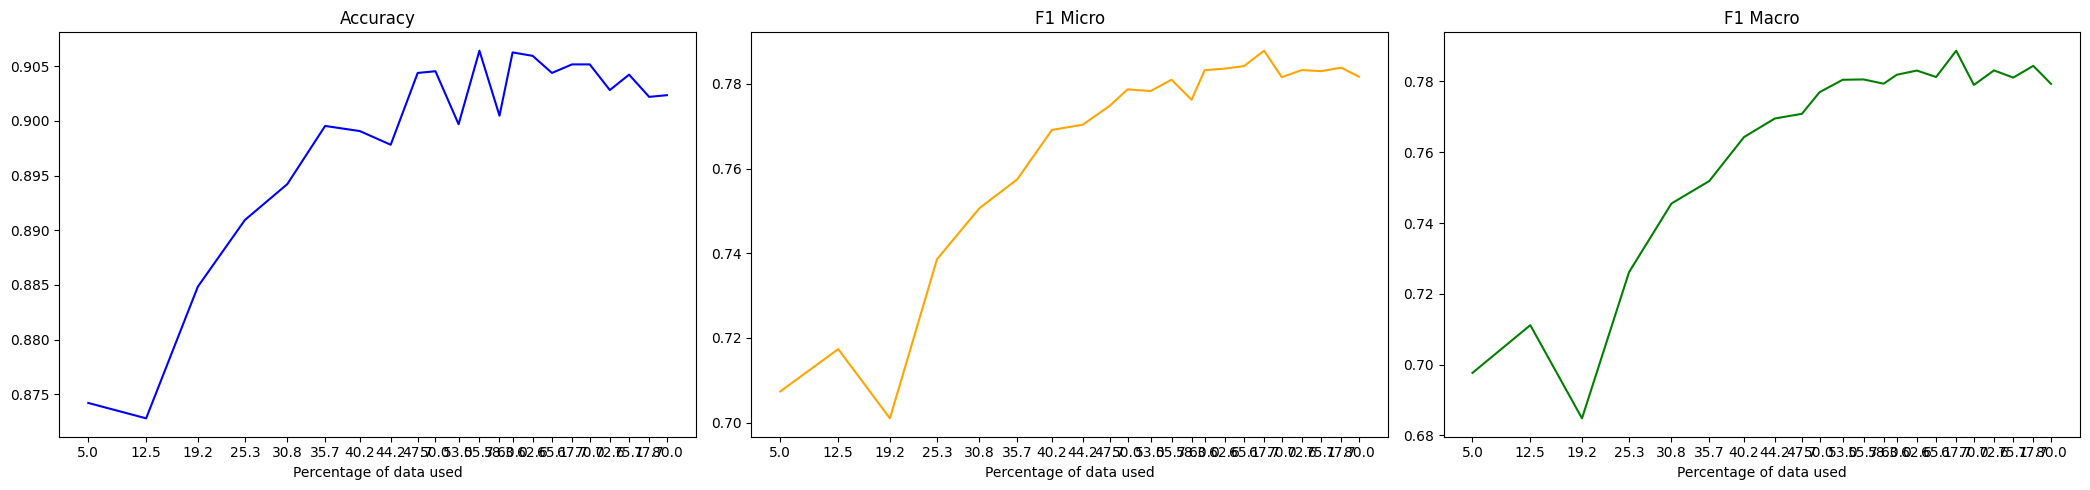

In [ ]:
active_learning(seeds[4], 4)